In [2]:
# 相关库的导入
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit  # 非线性拟合工具
from sklearn.metrics import r2_score  # 计算拟合优度R²
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']                 # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False                   # 用来正常显示负号


In [3]:
# 导入数据

# 1. 设置文件路径
excel_path = 'monod_practice_data.xlsx'

# 2. 读取Excel文件
df = pd.read_excel(
    excel_path,
    sheet_name=0,              # 读取工作表
    na_values=["", "NA", "缺失"],  # 定义哪些值视为空值
    dtype=float                   # 数据类型
)

# 3. 提取核心数据（对需要拟合的参数有影响的数据）
S = df['底物浓度(g/L)']
mu = df['比生长速率(h⁻¹)']

In [4]:
# 定义Monod方程
def monod(S, mu_max, K_s):
    '''用于非线性拟合时的方程形式'''
    return mu_max * S / (K_s + S)  # 直接对应Monod方程形式

In [15]:
# 调包，拟合

# 1. 函数的相关参数设定
bounds =[
    [0.1,1.0],
    [1.5,3.5]
]

# 2. 使用函数

popt,pcov = curve_fit(
    f= monod,
    xdata= S,
    ydata= mu,
    bounds=bounds,
    p0= None,
    maxfev=100000
)

mu_max = popt[0]
K_s = popt[1]
print(f'最大比生长速率：{mu_max} 1/h')
print(f'半饱和参数：{K_s} g/L')
print(f'协方差矩阵：')
print(pcov)

最大比生长速率：0.745026341753806 1/h
半饱和参数：1.9215499790092792 g/L
协方差矩阵：
[[0.00037221 0.00423303]
 [0.00423303 0.06444851]]


拟合优度R² = 0.9297


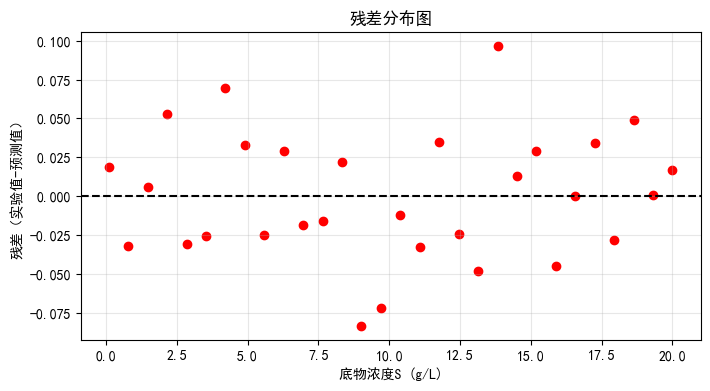

mu_max的标准误差：0.019292801449671985
K_s的标准误差：0.25386710722090206
mu_max的变异系数：2.5895462171520496%
K_s的变异系数：13.211579713986515%
mu_max和K_s的相关系数：0.8642700090876101


In [19]:
# 结果评估
# 1. R²
mu_pred = monod(S, mu_max, K_s)  # 用拟合参数预测μ
r2 = r2_score(mu, mu_pred)
print(f"拟合优度R² = {r2:.4f}")

# 2. 残差分析
residuals = mu - mu_pred
plt.figure(figsize=(8, 4))
plt.scatter(S, residuals, color='red')                # scatter --> 散点图 绘制残差散点图，随机分布说明效果好
plt.axhline(y=0, color='black', linestyle='--')  # 0基准线
plt.xlabel('底物浓度S (g/L)')
plt.ylabel('残差（实验值-预测值）')
plt.title('残差分布图')
plt.grid(alpha=0.3)
plt.show()

# 3. 协方差矩阵的使用

# （1）获得参数的标准误差SE（标准差，方差的平方根），即协方差矩阵的对角线元素
'''
SE 越小，参数估计越可靠：说明实验数据对该参数的约束能力强，拟合结果更可信；
SE 越大，参数估计越不可靠：可能是数据量不足、数据噪声大，或模型对该参数不敏感
'''
se_mu_max = np.sqrt(pcov[0,0])                  # mu_max 的标准差
se_K_s = np.sqrt(pcov[1,1])                      # K_s 的标准差

# （2）由SE计算参数的变异系数CV
cv_mu_max = (se_mu_max / mu_max) * 100  # mu_max的变异系数
cv_K_S = (se_K_s / K_s) * 100           # K_S的变异系数

# （3）计算参数的相关系数
corr_mu_max_K_s = pcov[0, 1] / (se_mu_max * se_K_s)  # 两参数的相关系数

print(f'mu_max的标准误差：{se_mu_max}')
print(f'K_s的标准误差：{se_K_s}')
print(f'mu_max的变异系数：{cv_mu_max}%')
print(f'K_s的变异系数：{cv_K_s}%')
print(f'mu_max和K_s的相关系数：{corr_mu_max_K_s}')

### 结果分析
- 残差无明显趋势，分布随机，模型无系统偏差;
- 拟合优度 R²=0.9297，说明模型的拟合效果良好；
- 标准误差，$SE (\mu_{max})$ =0.0193、$SE (K_s)$=0.2539，数值合理；
- 变异系数，$CV (\mu_{max})$=2.59%、$CV (K_s)$=13.21%），均达可接受标准;
- 参数相关系数，0.864（强相关），工程应用可用，基础研究需补低浓度数据。

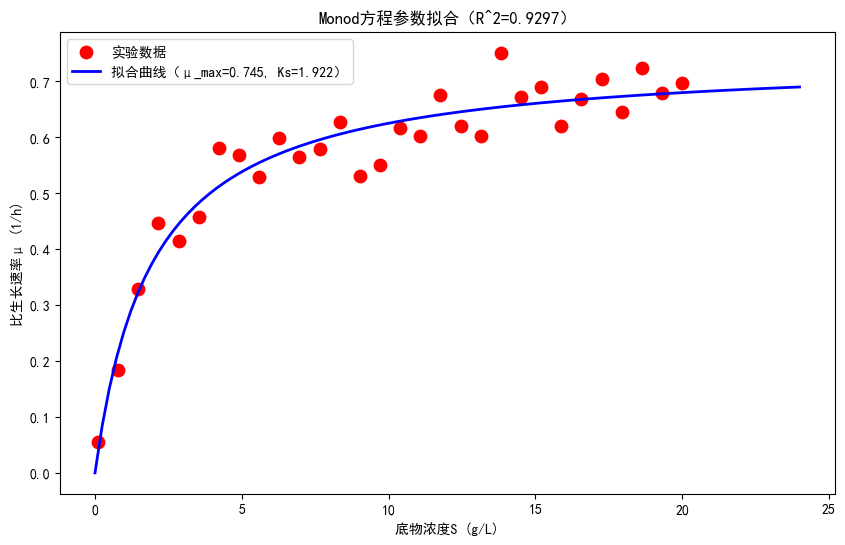

In [30]:
# 可视化对比
# 生成密集的S值，用于绘制平滑曲线
S_range = np.linspace(0, max(S)*1.2, 100)      # 生成密集的S值，用于绘制平滑曲线
mu_fit_curve = monod(S_range, mu_max, K_s)  # 拟合曲线

plt.figure(figsize=(10, 6))
plt.scatter(S, mu, color='red', s=80, label='实验数据')  # 实验点
plt.plot(S_range, mu_fit_curve, 'b-', linewidth=2, label=f'拟合曲线（μ_max={mu_max:.3f}, Ks={K_s:.3f}）')  # 拟合曲线
plt.xlabel('底物浓度S (g/L)')
plt.ylabel('比生长速率μ (1/h)')
plt.title(f'Monod方程参数拟合（R^2={r2:.4f}）')
plt.legend()
plt.show()